# The Red Line Problem

This notebook is based on an exercise in [Think Bayes, 2nd edition](https://greenteapress.com/wp/think-bayes/):

> The Red Line is a subway that connects Cambridge and Boston, Massachusetts. When I was working in Cambridge I took the Red Line from Kendall Square to South Station and caught the commuter rail to Needham. During rush hour Red Line trains run every 7–8 minutes, on average.
>
> When I arrived at the subway stop, I could estimate the time until the next train based on the number of passengers on the platform. If there were only a few people, I inferred that I just missed a train and expected to wait about 7 minutes. If there were more passengers, I expected the train to arrive sooner. But if there were a large number of passengers, I suspected that trains were not running on schedule, so I would leave the subway stop and get a taxi.
>
> While I was waiting for trains, I thought about how Bayesian inference could help predict my wait time and decide when I should give up and take a taxi. This example presents the analysis I came up with.

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate

Before we get to the analysis, we have to make some modeling decisions. First, I will treat passenger arrivals as a Poisson process, which means I assume that passengers are equally likely to arrive at any time, and that they arrive at a rate, λ, measured in passengers per minute. Since I observe passengers during a short period of time, and at the same time every day, I assume that λ is constant.

On the other hand, the arrival process for trains is not Poisson. Trains to Boston are supposed to leave from the end of the line (Alewife station) every 7–8 minutes during peak times, but by the time they get to Kendall Square, the time between trains varies between 3 and 12 minutes.

To gather data on the time between trains, I wrote a script that downloads real-time data from the [MBTA](http://www.mbta.com/rider_tools/developers/), selects south-bound trains arriving at Kendall Square, and records their arrival times in a database. I ran the script from 4 pm to 6 pm every weekday for 5 days, and recorded about 15 arrivals per day. Then I computed the time between consecutive arrivals.
Here are the gap times I recorded, in seconds.

In [4]:
observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]) / 60

I'll use KDE to estimate the distribution of gap times.

In [5]:
from scipy.stats import gaussian_kde

kde_gap = gaussian_kde(observed_gap_times)

If you arrive at the station at a random time, you are more likely to arrive during a long gap than a small one.
To estimate the distribution of gap times -- as seen by a random arrival -- we can use KDE again, with the gap times themselves as weights.
For more about this kind of length-biased sampling, see Chapter 2 of [*Probably Overthinking It*](https://probablyoverthinking.it).

In [6]:
kde_prior = gaussian_kde(observed_gap_times, weights=observed_gap_times)

Here's what these distributions look like -- the actual distribution of times between trains and the observed distribution as seen by a random arrival.

In [7]:
def plot_kde(kde, **options):
    xs = np.linspace(0, 20, 101)
    ps = kde(xs)
    plt.plot(xs, ps, **options) 

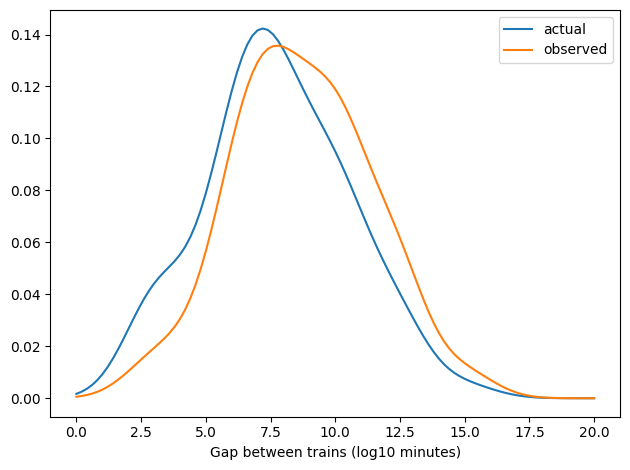

In [8]:
plot_kde(kde_gap, label='actual')
plot_kde(kde_prior, label='observed')

decorate(xlabel='Gap between trains (log10 minutes)')

## Model 1: KDE prior of gap times

In [9]:
# Modified version based on the example at
# from https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html

def kde_from_sample(name, sample):
    m = np.mean(sample)
    s = np.std(sample)
    low, high = np.min(sample), np.max(sample)
    
    x = np.linspace(0, high+s, 101)
    y = gaussian_kde(sample)(x)

    # pad the domain with zeros
    x = np.concatenate([[x[0] - 3 * s], x, [x[-1] + 3 * s]])
    y = np.concatenate([[0], y, [0]])
    
    return pm.Interpolated(name, x, y)

In [10]:
import pymc as pm  

# gap_time: interpolated
# rate: Normal

def make_model1(n_obs=10):
    """Make a model of the red line problem.
    
    n_obs: observed passengers
    """
    model = pm.Model()
    with model:
        gap_time = kde_from_sample('gap_time', observed_gap_times)
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 2: Normal prior of gap times

In [11]:
from empiricaldist import Pmf

xs = np.linspace(0, 25, 101)
ps = kde_prior.evaluate(xs)
pmf_prior = Pmf(ps, xs)
pmf_prior.normalize()
cdf_prior = pmf_prior.make_cdf()

In [12]:
m, s = pmf_prior.mean(), pmf_prior.std()
m, s

(8.72211014890576, 2.8568243405679636)

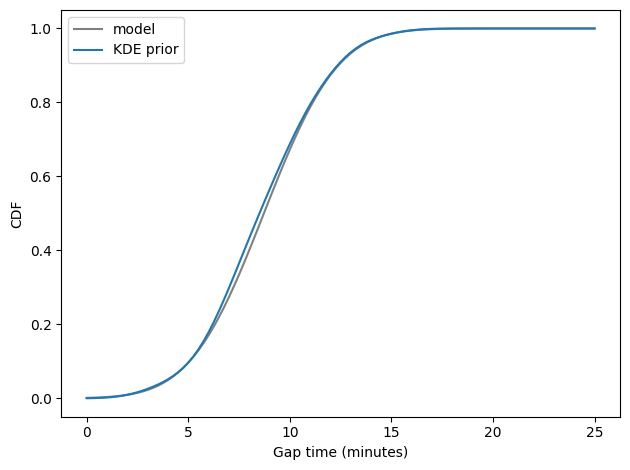

In [13]:
from scipy.stats import norm

xs = np.linspace(0, 25, 101)
ps = norm.cdf(xs, loc=m, scale=s)

plt.plot(xs, ps, color='gray', label='model')
cdf_prior.plot(label='KDE prior')

decorate(xlabel='Gap time (minutes)', ylabel='CDF')

In [14]:
import pymc as pm  

# gap_time: Normal
# rate: Normal

def make_model2(n_obs=10):
    model = pm.Model()
    with model:
        gap_time = pm.Normal('gap_time', mu=m, sigma=s)
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 3: Lognormal prior of gap times

In [15]:
from scipy.stats import lognorm

def lognormal_cdf(xs, m, s):
    return lognorm.cdf(xs, s, scale=np.exp(m))

In [16]:
def residuals(params, xs, cdf_prior):
    m, s = params
    ps = lognormal_cdf(xs, m, s)
    return ps - cdf_prior.ps

In [17]:
from scipy.optimize import least_squares

initial_guess = [2, 0.4]
result = least_squares(residuals, initial_guess, args=(xs, cdf_prior))
assert result.success == True

In [18]:
m, s = result.x
m, s

(2.1216720834729106, 0.32970258408082936)

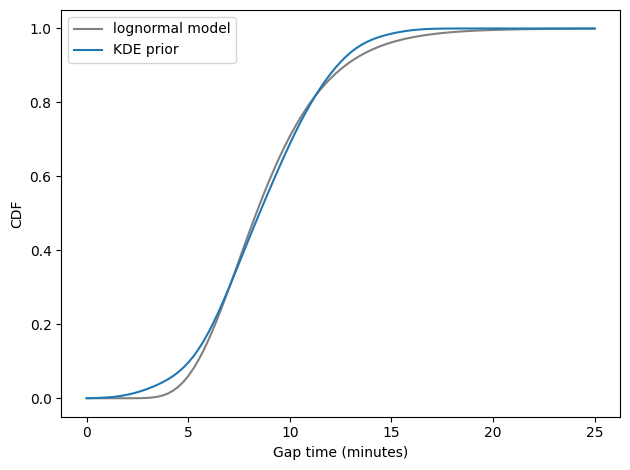

In [19]:
ps = lognormal_cdf(xs, m, s)
plt.plot(xs, ps, color='gray', label='lognormal model')

pmf_prior.make_cdf().plot(label='KDE prior')
decorate(xlabel='Gap time (minutes)', ylabel='CDF')

In [20]:
import pymc as pm  

# gap_time: Lognormal
# rate: Normal

m, s = result.x

def make_model3(n_obs=10):

    model = pm.Model()
    with model:
        log_time = pm.Normal('log_time', mu=m, sigma=s)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Normal('rate', mu=2, sigma=0.1)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 4: gamma prior of rates

In [21]:
mu = 2
sigma = 0.5

alpha = (mu/sigma)**2
beta = mu / sigma**2

alpha, beta

(16.0, 8.0)

In [22]:
from scipy.stats import gamma

gamma_dist = gamma(a=alpha, scale=1/beta)
gamma_dist.mean(), gamma_dist.std()

(2.0, 0.5)

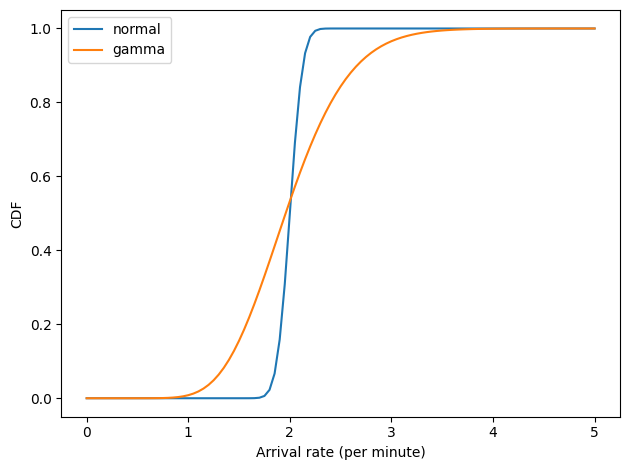

In [23]:
xs = np.linspace(0, 5, 101)
ps = norm.cdf(xs, 2, 0.1)
plt.plot(xs, ps, label='normal')

ps = gamma_dist.cdf(xs)
plt.plot(xs, ps, label='gamma')

decorate(xlabel='Arrival rate (per minute)', ylabel='CDF')

In [24]:
import pymc as pm  

# gap_time: Lognormal
# rate: Gamma

m, s = result.x

def make_model4(n_obs=10):

    model = pm.Model()
    with model:
        log_time = pm.Normal('log_time', mu=m, sigma=s)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Gamma('rate', alpha=alpha, beta=beta)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

## Model 5: Log-t prior of gap times


In [25]:
nu = 7

In [26]:
from scipy.stats import t as student_t

def log_t_cdf(xs, m, s, nu):
    return student_t.cdf(np.log(xs), loc=m, scale=s, df=nu)

In [27]:
def residuals(params, xs, cdf_prior):
    m, s = params
    ps = log_t_cdf(xs, m, s, nu=nu)
    return ps - cdf_prior.ps

In [28]:
from scipy.optimize import least_squares

initial_guess = [m, s]
xs = np.linspace(0.01, 25, 101)
result = least_squares(residuals, initial_guess, args=(xs, cdf_prior))
assert result.success == True

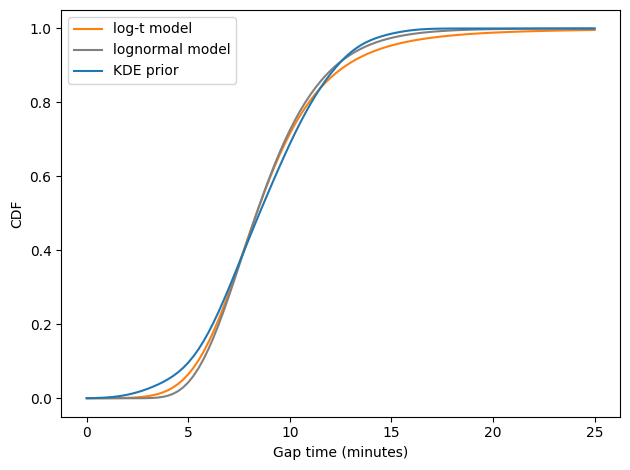

In [29]:
m, s = result.x
ps = log_t_cdf(xs, m, s, nu=nu)
plt.plot(xs, ps, color='C1', label='log-t model')

xs = np.linspace(0, 25, 101)
ps = lognormal_cdf(xs, m, s)
plt.plot(xs, ps, color='gray', label='lognormal model')

pmf_prior.make_cdf().plot(label='KDE prior')
decorate(xlabel='Gap time (minutes)', ylabel='CDF')

In [30]:
import pymc as pm  

# gap_time: StudentT
# rate: Gamma

m, s = result.x

def make_model5(n_obs=10):

    model = pm.Model()
    with model:
        log_time = pm.StudentT('log_time', mu=m, sigma=s, nu=nu)
        gap_time = pm.Deterministic('gap_time', pm.math.exp(log_time))
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Gamma('rate', alpha=alpha, beta=beta)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

In [31]:
make_model = make_model5

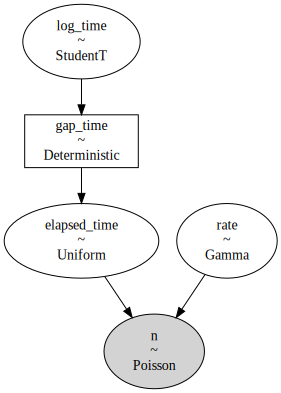

In [32]:
model = make_model(n_obs=10)
pm.model_to_graphviz(model)

In [33]:
with model:
    idata = pm.sample(500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


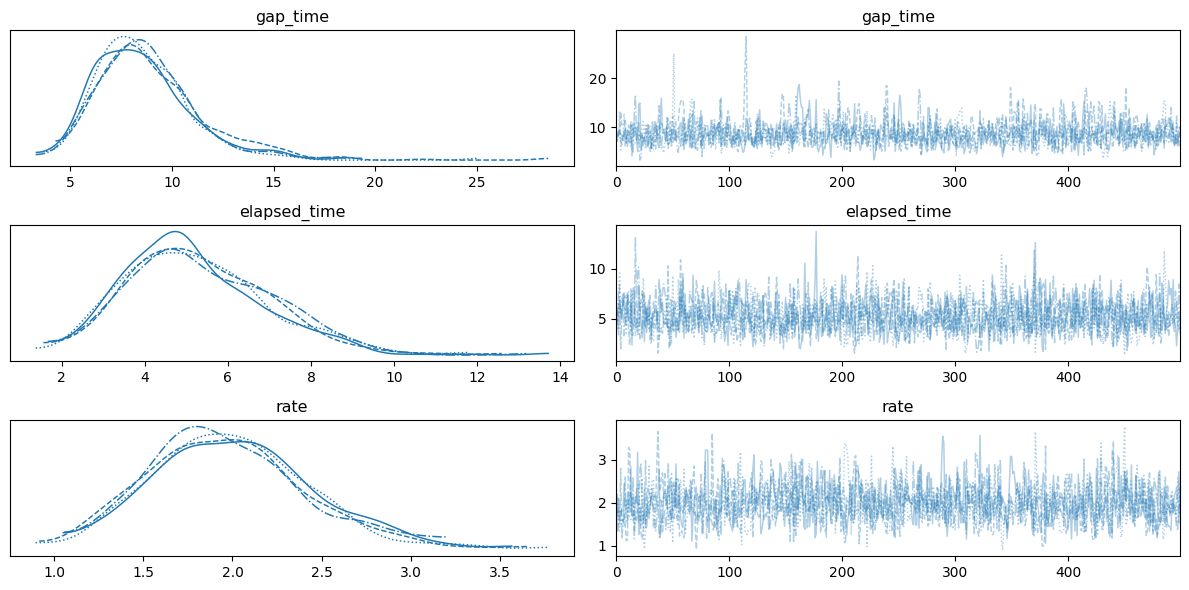

In [34]:
import arviz as az

var_names=['gap_time', 'elapsed_time', 'rate']

with model:
    az.plot_trace(idata, var_names=var_names)
    
plt.tight_layout()

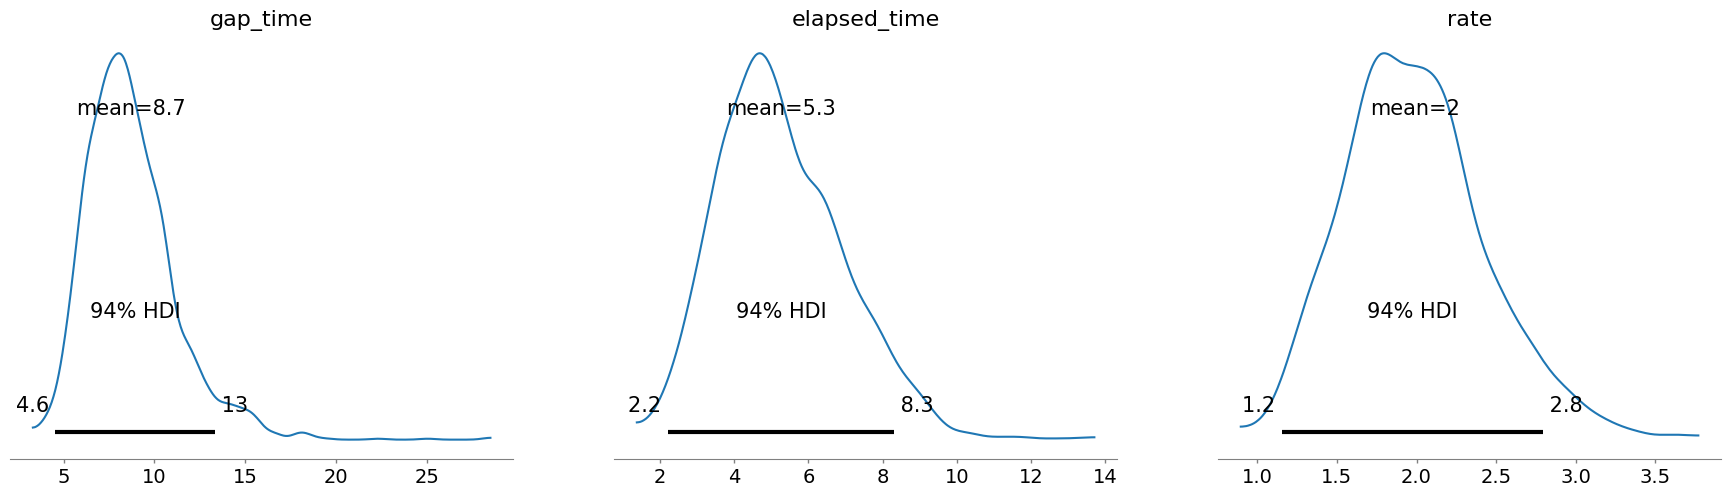

In [35]:
import arviz as az

with model:
    az.plot_posterior(idata, var_names=var_names)

In [36]:
def get_sample(idata, var_name):
    return idata.posterior[var_name].values.flatten()

rates = get_sample(idata, 'rate')
np.mean(rates)

1.9887937363087103

In [37]:
gap_times = get_sample(idata, 'gap_time')
np.mean(gap_times)

8.702411447440674

In [38]:
elapsed_times = get_sample(idata, 'elapsed_time')
np.mean(elapsed_times)

5.26024238176017

In [39]:
remaining_times = gap_times - elapsed_times
np.mean(remaining_times)

3.4421690656805035

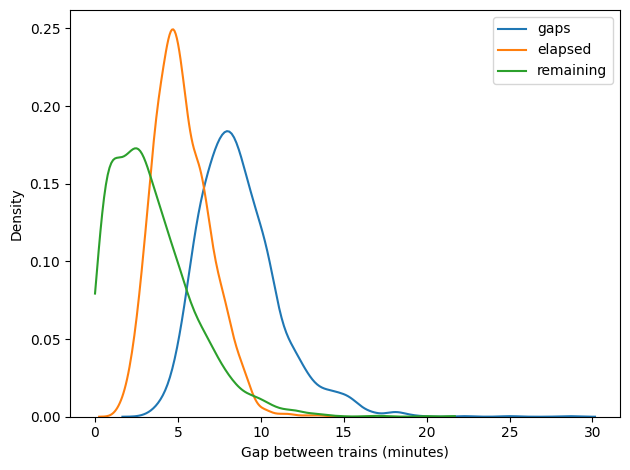

In [40]:
import seaborn as sns

sns.kdeplot(gap_times, label='gaps')
sns.kdeplot(elapsed_times, label='elapsed')
sns.kdeplot(remaining_times, label='remaining', cut=0)

decorate(xlabel='Gap between trains (minutes)')

## Correlations

In [41]:
np.corrcoef([gap_times, elapsed_times, rates])

array([[ 1.        ,  0.30127927, -0.13318301],
       [ 0.30127927,  1.        , -0.51871121],
       [-0.13318301, -0.51871121,  1.        ]])

In [42]:
def joint_contour(x, y):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    xs = np.linspace(x.min(), x.max(), 101)
    ys = np.linspace(y.min(), y.max(), 101)
    X, Y = np.meshgrid(xs, ys, indexing='ij')

    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_values = kde(positions).reshape(X.shape)

    plt.contour(X, Y, kde_values, cmap='Blues')

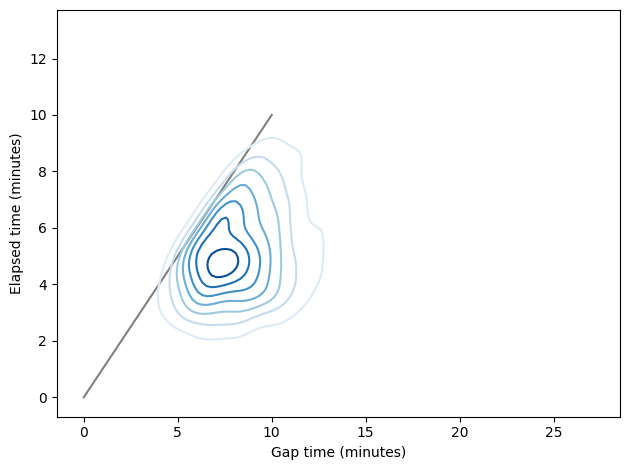

In [43]:
plt.plot([0, 10], [0, 10], color='gray')
joint_contour(gap_times, elapsed_times)
decorate(xlabel='Gap time (minutes)', ylabel='Elapsed time (minutes)')

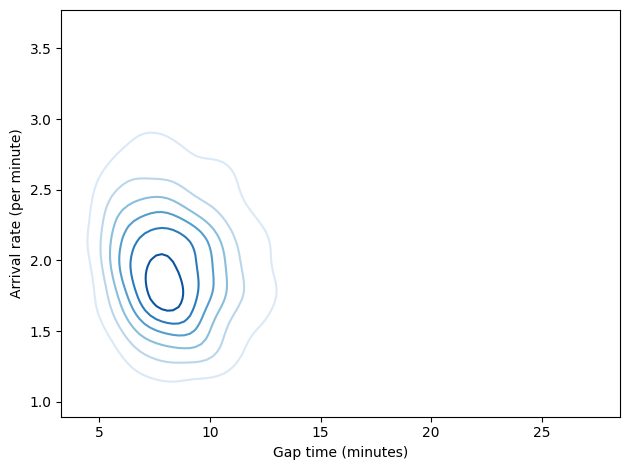

In [44]:
joint_contour(gap_times, rates)
decorate(xlabel='Gap time (minutes)', ylabel='Arrival rate (per minute)')

## Run with a range of n_obs

In [45]:
def run_model(make_model_func):
    """
    """
    gap_df = pd.DataFrame(dtype='float')
    elapsed_df = pd.DataFrame(dtype='float')
    remaining_df = pd.DataFrame(dtype='float')
    rate_df = pd.DataFrame(dtype='float')

    # run the model with a range of n_obs
    for n_obs in [2, 5, 10, 20, 30, 40]:
        print(n_obs)
        model = make_model_func(n_obs)
        with model:
            idata = pm.sample(500, tune=500)

        gap_times = get_sample(idata, 'gap_time')
        gap_df[n_obs] = gap_times

        elapsed_times = get_sample(idata, 'elapsed_time')
        elapsed_df[n_obs] = elapsed_times

        remaining_df[n_obs] = gap_times - elapsed_times

        rate_df[n_obs] = get_sample(idata, 'rate')

    # save the results in an HDF file
    model_name = make_model_func.__name__.split('_')[1]
    varnames = ['gap', 'elapsed', 'remaining', 'rate']
    dataframes = [gap_df, elapsed_df, remaining_df, rate_df]

    for varname, df in zip(varnames, dataframes):
        key = f'{model_name}_{varname}'
        df.to_hdf('redline.hdf', key=key)

In [46]:
make_model_funcs = [make_model1, make_model2, make_model3, make_model4, make_model5]

for make_model_func in make_model_funcs:
    run_model(make_model_func)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gap_time, elapsed_time, rate]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


model1_gap
model1_elapsed
model1_remaining
model1_rate


In [47]:
def get_result(model_name, varname):
    key = f'{model_name}_{varname}'
    return pd.read_hdf('redline.hdf', key=key)

model1_remaining


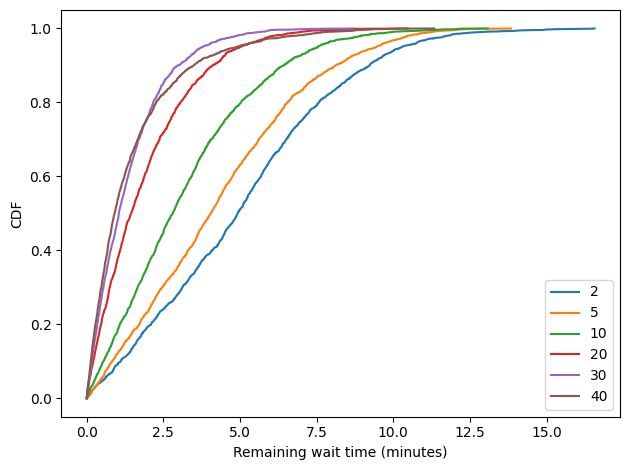

In [48]:
from empiricaldist import Cdf

def plot_cdfs(model_name, varname):
    df = get_result(model_name, varname)
    
    for n_obs, sample in df.items():
        cdf = Cdf.from_seq(sample)
        cdf.plot(label=n_obs)

    decorate(ylabel='CDF')
    
plot_cdfs('model1', 'remaining')
decorate(xlabel='Remaining wait time (minutes)')

In [54]:
def plot_model_results(models, varname):
    for i in models:
        model_name = f'model{i}'
        df = get_result(model_name, varname)
        df.mean().plot(label=model_name)

model1_remaining


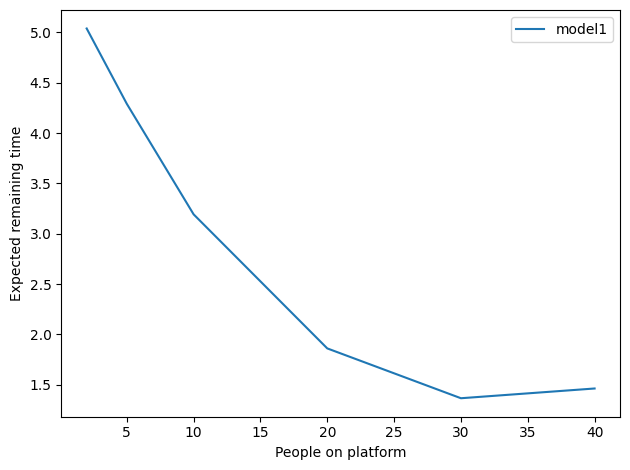

In [55]:
plot_model_results([1], 'remaining')
decorate(xlabel='People on platform', ylabel='Expected remaining time')

model1_gap


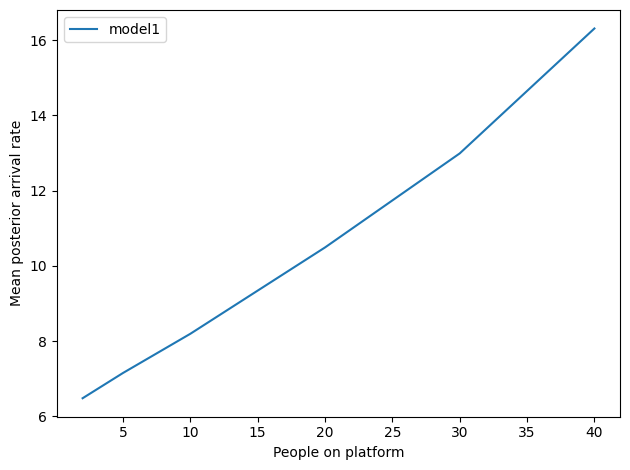

In [56]:
plot_model_results([1], 'gap')
decorate(xlabel='People on platform', ylabel='Mean posterior arrival rate')

## Compare models

model1_gap
model2_gap


KeyError: 'No object named model2_gap in the file'

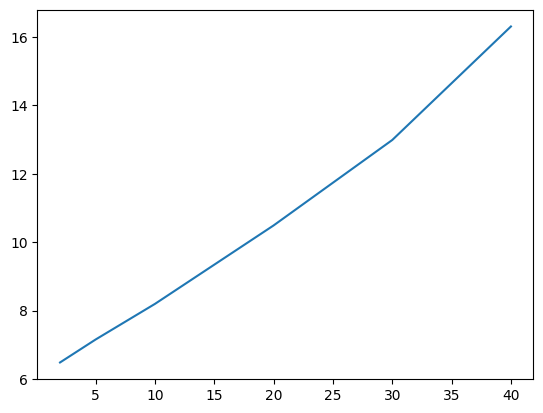

In [61]:
all_models = range(1, 6)

plot_model_results(all_models, 'gap')
decorate(xlabel='People on platform', ylabel='Mean posterior gap time (minutes)')

model1_elapsed


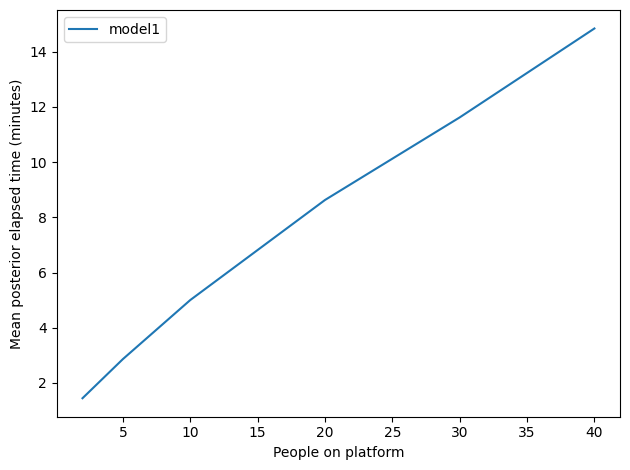

In [58]:
plot_model_results(all_models, 'elapsed')
decorate(xlabel='People on platform', ylabel='Mean posterior elapsed time (minutes)')

model1_remaining


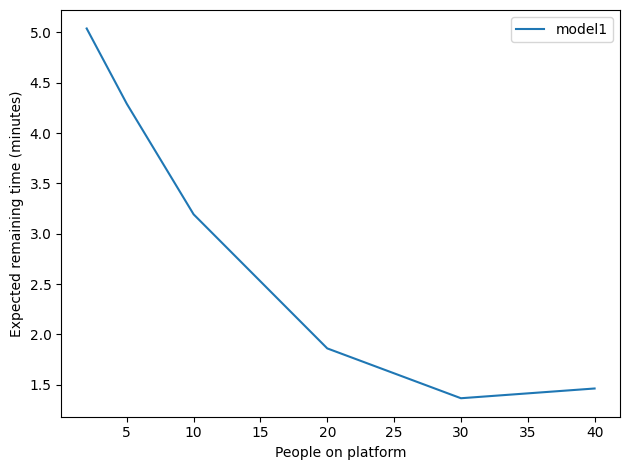

In [59]:
plot_model_results(all_models, 'remaining')
decorate(xlabel='People on platform', ylabel='Expected remaining time (minutes)')

model1_rate


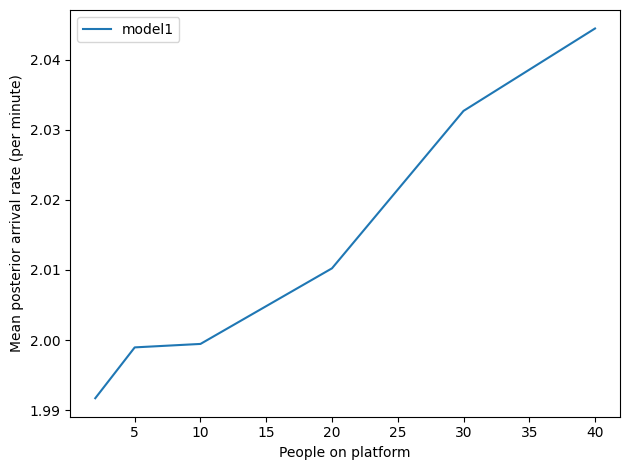

In [60]:
plot_model_results(all_models, 'rate')
decorate(xlabel='People on platform', ylabel='Mean posterior arrival rate (per minute)')

Think Bayes, Second Edition

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)